In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import pandas as pd
from sqlalchemy import create_engine

# Paramètres pour la connexion à SQL Server
server = 'DIRAR'
database = 'DATA WAREHOUSE'
username = 'sa'
password = 'azerty123'

# Création du moteur SQLAlchemy pour SQL Server
engine = create_engine(
    f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'
)

# Charger les tables nécessaires dans des DataFrames pandas
dim_admission = pd.read_sql("SELECT * FROM dim_admission", engine)
dim_patients = pd.read_sql("SELECT * FROM dim_patients", engine)
dim_doctor = pd.read_sql("SELECT * FROM dim_doctor", engine)
dim_reclamation = pd.read_sql("SELECT * FROM dim_reclamation", engine)
dim_temps = pd.read_sql("SELECT * FROM dim_temps", engine)
satisfaction_fact = pd.read_sql("SELECT * FROM satisfaction_fact", engine)

# Affichage de quelques lignes pour vérifier
print(dim_admission.head())
print(dim_patients.head())

   hadm_id admission_type         admission_location        discharge_location
0   100375      EMERGENCY  TRANSFER FROM HOSP/EXTRAM                       SNF
1   100969      EMERGENCY       EMERGENCY ROOM ADMIT              DEAD/EXPIRED
2   101361      EMERGENCY  TRANSFER FROM HOSP/EXTRAM  REHAB/DISTINCT PART HOSP
3   103379      EMERGENCY       EMERGENCY ROOM ADMIT          HOME HEALTH CARE
4   103770      EMERGENCY       EMERGENCY ROOM ADMIT  REHAB/DISTINCT PART HOSP
   subject_id insurance language  religion marital_status  \
0       10006  Medicare           CATHOLIC      SEPARATED   
1       10011   Private           CATHOLIC         SINGLE   
2       10013  Medicare           CATHOLIC                  
3       10017  Medicare           CATHOLIC       DIVORCED   
4       10019  Medicare           CATHOLIC       DIVORCED   

                ethnicity  
0  BLACK/AFRICAN AMERICAN  
1   UNKNOWN/NOT SPECIFIED  
2   UNKNOWN/NOT SPECIFIED  
3                   WHITE  
4                  

In [12]:
clustering_df = satisfaction_fact[['Satisfaction_Impact', 'Resolution_Duration_Days']].copy()

# Handle missing values (if any) by dropping rows
clustering_df.dropna(inplace=True, axis=0)

# Check the shape after dropping NaNs
print(f"\nShape of clustering data after handling missing values: {clustering_df.shape}")


Shape of clustering data after handling missing values: (20, 2)


In [14]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_df)

# Convert the scaled features back to a DataFrame (optional, but can be helpful for inspection)
scaled_df = pd.DataFrame(scaled_features, columns=['Satisfaction_Impact_Scaled', 'Resolution_Duration_Days_Scaled'])
print("\nScaled Data:")
print(scaled_df.head())


Scaled Data:
   Satisfaction_Impact_Scaled  Resolution_Duration_Days_Scaled
0                    0.896258                        -0.179987
1                    1.536443                        -0.497612
2                    0.256074                         0.137637
3                   -1.024295                         0.984637
4                   -1.024295                         0.561137


C:\Users\bdrdi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\bdrdi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\bdrdi\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bdrdi\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\bdrdi\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(e

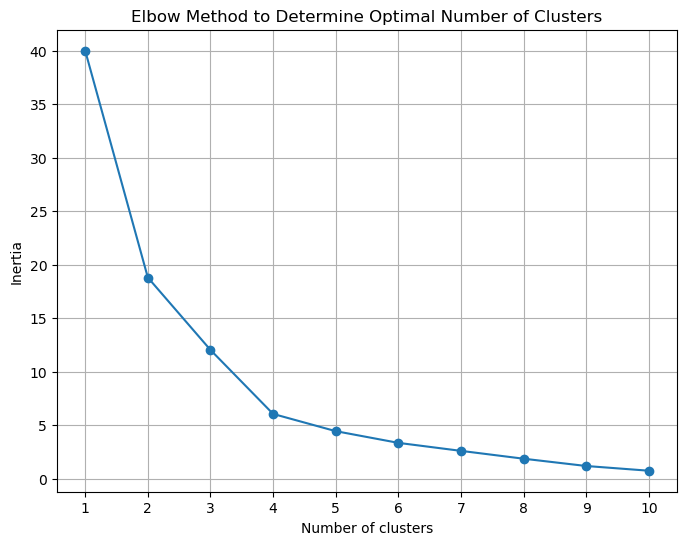

In [16]:
inertia = []
range_n_clusters = range(1, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertia, marker='o', linestyle='-')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

# Analyze the elbow plot to decide on the optimal number of clusters.
# Look for the "elbow" point where the decrease in inertia starts to slow down.

In [62]:
n_clusters_optimal = 3  # <--- REPLACE WITH YOUR CHOSEN NUMBER

kmeans = KMeans(n_clusters=n_clusters_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels back to the original DataFrame
clustering_df['Cluster'] = clusters

print("\nClustered Data with Labels:")
print(clustering_df.head())


Clustered Data with Labels:
   Satisfaction_Impact  Resolution_Duration_Days  Cluster
0                    4                        15        2
1                    5                        12        0
2                    3                        18        2
3                    1                        26        1
4                    1                        22        1


C:\Users\bdrdi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


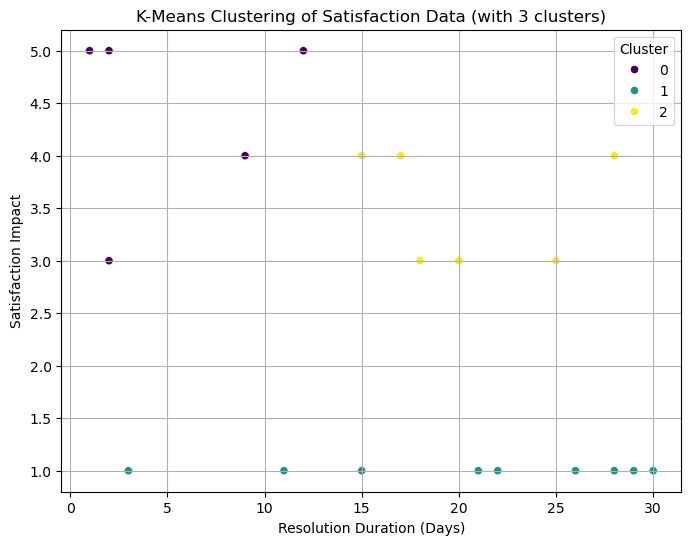

In [64]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=clustering_df, x='Resolution_Duration_Days', y='Satisfaction_Impact', hue='Cluster', palette='viridis')
plt.title(f'K-Means Clustering of Satisfaction Data (with {n_clusters_optimal} clusters)')
plt.xlabel('Resolution Duration (Days)')
plt.ylabel('Satisfaction Impact')
plt.grid(True)
plt.show()

In [66]:
cluster_analysis = clustering_df.groupby('Cluster').agg(
    Average_Satisfaction=('Satisfaction_Impact', 'mean'),
    Average_Resolution_Days=('Resolution_Duration_Days', 'mean'),
    Count=('Cluster', 'count')
).reset_index()
print("\nCluster Analysis:")
print(cluster_analysis)


Cluster Analysis:
   Cluster  Average_Satisfaction  Average_Resolution_Days  Count
0        0                   4.4                 5.200000      5
1        1                   1.0                20.555556      9
2        2                   3.5                20.500000      6
